In [2]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import time

import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019.get_dataframe()
print('loaded file 2019')

NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021.get_dataframe()
print('loaded file 2020')

NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020.get_dataframe()
print('loaded file 2021')

NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022.get_dataframe()
print('loaded file 2022')

NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()
print('loaded annual card count')

HFM_cost_by_MRU = dataiku.Dataset("HFM_cost_by_MRU")
HFM_cost_by_MRU_df = HFM_cost_by_MRU.get_dataframe()
print('loaded HFM cost data')

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

loaded file 2019
loaded file 2020
loaded file 2021


/data/dataiku/dss_data/code-envs/python/env_clc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


loaded file 2022
loaded annual card count
loaded HFM cost data
load duration 6.101883061726888 minutes


In [3]:
row_count = 0
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019_df)
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020_df)
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021_df)
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022_df)
print(row_count)

df = pd.concat([NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019_df, NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020_df,
               NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021_df, NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022_df])

print(len(df), "NAFCUSTOMER REVENUE AGGREGATED")

print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df

19405984
19405984 NAFCUSTOMER REVENUE AGGREGATED
2319568 NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df


In [4]:
df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])
df['SETUP_YEAR'] = df.SETUP_DATE_DT.dt.year

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

df['MRU'] = df.BI_MRU
df.loc[df.MRU.isnull(),'MRU'] = 3100
df.loc[df.MRU=='TBD','MRU'] = 3100
df['MRU'] = df['MRU'].astype(float)
df['MRU'] = df['MRU'].astype('Int64')
df.MRU.value_counts()

print(len(df), "before filter")
df = df[df.REVENUE_YEAR!=2023]
print(len(df), "after filter, removing 2023")

# break down of revenue_year
df.REVENUE_YEAR.value_counts()

df.head()

19405984 before filter
19405984 after filter, removing 2023


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,CUSTOMER_BUSINESS_PROGRAM_NAME,BI_CUS_PAR,BI_PRODUCT,BI_MRU,SETUP_DATE,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT,SETUP_DATE_DT,SETUP_YEAR,REVENUE_DATE,MRU
0,77553684,STATE OF IOWA,2019,11,Wright Express Fleet Universal,"51,000.0","10,100.0","3,100.0",2013-08-19 07:00:00+00:00,"22,705.96","1,450,884.46","563,755.553","6,505.0",2013-08-19 07:00:00+00:00,2013,11-2019,3100
1,77214249,EVANGELISTO CONSTRUCTION LLC,2019,1,Sunoco Universal,"51,200.0","15,308.0","4,120.0",2018-08-30 07:00:00+00:00,23.15,652.98,297.782,4.0,2018-08-30 07:00:00+00:00,2018,01-2019,4120
2,77434788,OLIVER SERVICES LLC,2019,12,Chevron and Texaco Business Access,"11,200.0","15,308.0","4,000.0",2018-04-11 07:00:00+00:00,68.83,303.8,105.42299999999999,1.0,2018-04-11 07:00:00+00:00,2018,12-2019,4000
3,77540790,SOI AVIATION INC,2019,3,Chevron and Texaco Business,"11,200.0","15,100.0","4,000.0",2018-12-03 08:00:00+00:00,85.0,111.44,29.159000000000002,1.0,2018-12-03 08:00:00+00:00,2018,03-2019,4000
4,77381882,MASCO CANADA LTD,2019,5,Esso Business Premier Plus,"20,800.0","15,100.0","4,000.0",2014-11-03 08:00:00+00:00,76.46,"8,498.36","2,102.5557",25.0,2014-11-03 08:00:00+00:00,2014,05-2019,4000


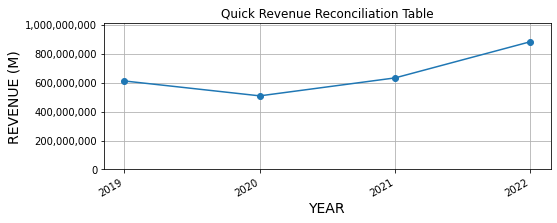

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,"611,886,393.7099723"
1,2020,"508,936,503.09999055"
2,2021,"633,153,608.6199423"
3,2022,"883,294,206.3301082"


In [5]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# plot out sum of revenue per year
# in order to do a quick reonciliation against

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.REVENUE_AMOUNT_USD = df_revenue_per_year.REVENUE_AMOUNT_USD
df_revenue_per_year.head()

max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()

chart_revenue_year = []
for y in df_revenue_per_year.REVENUE_YEAR.tolist():
    chart_revenue_year.append(str(y))

fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(chart_revenue_year,df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_revenue*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
plt.title('Quick Revenue Reconciliation Table')
plt.show()

df_revenue_per_year.head()

In [6]:
df_customer_MRU = df.groupby(['CUSTOMER_ID','CUSTOMER']).MRU.min().reset_index()
df_customer_program = df.groupby(['CUSTOMER_ID','CUSTOMER']).CUSTOMER_BUSINESS_PROGRAM_NAME.first().reset_index()

df_customer_revenue_by_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
print(len(df_customer_revenue_by_year))

df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer.columns = ['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR','ACTIVE_CARD_COUNT']
df_active_card_count_by_customer.head()

df_x = pd.merge(df_customer_revenue_by_year,df_active_card_count_by_customer, how='left', on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_x))

df_customer_fleet_size = df_active_card_count_by_customer.groupby(['CUSTOMER_ID','CUSTOMER']).ACTIVE_CARD_COUNT.max().reset_index()
df_customer_fleet_size.columns = ['CUSTOMER_ID', 'CUSTOMER', 'FLEET_SIZE']

df_x = pd.merge(df_x, df_customer_fleet_size, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_x))

df_x = pd.merge(df_x, df_customer_MRU, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_x))

df_x = pd.merge(df_x, df_customer_program, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_x))

df_x.loc[df_x.FLEET_SIZE.isnull(),'FLEET_SIZE'] = 0
df_x['FLEET_SIZE_GROUP'] = 'NOT SET'
df_x.loc[df_x.FLEET_SIZE.between(0,5),'FLEET_SIZE_GROUP'] = '(<=5 cards)'
df_x.loc[df_x.FLEET_SIZE.between(6,100),'FLEET_SIZE_GROUP'] = '(between 6 and 100 cards)'
df_x.loc[df_x.FLEET_SIZE>100,'FLEET_SIZE_GROUP'] = '(>100 cards)'
df_x.head()

df_x.loc[df_x.CUSTOMER_BUSINESS_PROGRAM_NAME=='WEX Universal','MRU'] = 4120
df_x.head()

1777729
1777729
1777729
1777729
1777729


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_AMOUNT_USD,ACTIVE_CARD_COUNT,FLEET_SIZE,MRU,CUSTOMER_BUSINESS_PROGRAM_NAME,FLEET_SIZE_GROUP
0,77000000,1 AUTO PARTS INC,2019,175.47,1.0,1.0,4120,Sunoco Fleet,(<=5 cards)
1,77000001,94775 J AND J SNACK FOODS AA,2022,74.15,3.0,3.0,3100,Element Millennium,(<=5 cards)
2,77000002,APOSTROPHE DESIGN INC,2019,177.47000000000003,4.0,8.0,4000,Shell Small Business,(between 6 and 100 cards)
3,77000002,APOSTROPHE DESIGN INC,2020,271.6,4.0,8.0,4000,Shell Small Business,(between 6 and 100 cards)
4,77000002,APOSTROPHE DESIGN INC,2021,243.51,8.0,8.0,4000,Shell Small Business,(between 6 and 100 cards)


In [7]:
revenue_by_MRU = df_x.groupby(['REVENUE_YEAR','MRU']).REVENUE_AMOUNT_USD.sum().reset_index()
revenue_by_MRU[revenue_by_MRU.REVENUE_YEAR.isin([2020,2021])].sort_values(by='REVENUE_YEAR')
revenue_by_MRU

,REVENUE_YEAR,MRU,REVENUE_AMOUNT_USD
0,2019,3100,"143,739,268.85212037"
1,2019,4000,"126,312,050.32255584"
2,2019,4120,"341,835,074.5353252"
3,2020,3100,"111,649,921.17165461"
4,2020,4000,"118,696,172.50555496"
5,2020,4120,"278,590,947.1227956"
6,2021,3100,"135,525,245.3410088"
7,2021,4000,"157,426,655.84217083"
8,2021,4120,"340,196,333.1168244"
9,2022,3100,"167,721,449.0938082"


In [8]:
card_count_by_MRU = df_x.groupby(['MRU','REVENUE_YEAR']).ACTIVE_CARD_COUNT.sum().reset_index()
card_count_by_MRU = card_count_by_MRU[card_count_by_MRU.REVENUE_YEAR.isin([2020,2021])]
card_count_by_MRU

,MRU,REVENUE_YEAR,ACTIVE_CARD_COUNT
1,3100,2020,"3,645,369.0"
2,3100,2021,"3,720,990.0"
5,4000,2020,"2,194,730.0"
6,4000,2021,"2,547,874.0"
9,4120,2020,"2,268,161.0"
10,4120,2021,"2,522,808.0"


In [9]:
df_shared_costs = HFM_cost_by_MRU_df[HFM_cost_by_MRU_df.MRU==3000].copy()
df_shared_costs['SHARED_COST_USD'] = round(df_shared_costs.COST_AMOUNT_USD/3,2)
df_shared_costs = df_shared_costs[['COST_CATEGORY','TYPE','REVENUE_YEAR','SHARED_COST_USD']]

costs_with_shared_cost = HFM_cost_by_MRU_df[HFM_cost_by_MRU_df.MRU!=3000].copy()
print(len(costs_with_shared_cost))
costs_with_shared_cost = pd.merge(costs_with_shared_cost, df_shared_costs,how='left', on=['COST_CATEGORY','TYPE','REVENUE_YEAR'])
print(len(costs_with_shared_cost))
costs_with_shared_cost['TOTAL_COST_USD'] = costs_with_shared_cost.COST_AMOUNT_USD + costs_with_shared_cost.SHARED_COST_USD
costs_with_shared_cost.head()

42
42


,COST_CATEGORY,TYPE,REVENUE_YEAR,COST_AMOUNT_USD,MRU,SHARED_COST_USD,TOTAL_COST_USD
0,Provision for Credit Losses,COS Accounts,2021,"1,482,366.0",3100,"529,375.33","2,011,741.33"
1,Provision for Credit Losses,COS Accounts,2021,"12,686,420.0",4000,"529,375.33","13,215,795.33"
2,Provision for Credit Losses,COS Accounts,2021,"15,210,272.0",4120,"529,375.33","15,739,647.33"
3,Service Fees,COS Accounts,2021,"763,512.0",3100,168.33,"763,680.33"
4,Service Fees,COS Accounts,2021,"581,253.0",4000,168.33,"581,421.33"


In [10]:
df_cost_by_MRU_and_YEAR = costs_with_shared_cost.groupby(['REVENUE_YEAR','MRU']).TOTAL_COST_USD.sum().reset_index()
df_cost_by_MRU_and_YEAR

,REVENUE_YEAR,MRU,TOTAL_COST_USD
0,2020,3100,"59,316,752.0"
1,2020,4000,"55,779,372.0"
2,2020,4120,"50,219,539.0"
3,2021,3100,"54,125,678.33"
4,2021,4000,"65,597,957.33"
5,2021,4120,"53,702,502.660000004"


In [11]:
df_cost_and_card_count = pd.merge(card_count_by_MRU, df_cost_by_MRU_and_YEAR, on=['MRU','REVENUE_YEAR'])
df_cost_and_card_count['COST_PER_CARD'] = df_cost_and_card_count.TOTAL_COST_USD/df_cost_and_card_count.ACTIVE_CARD_COUNT
df_cost_and_card_count = df_cost_and_card_count[['MRU','REVENUE_YEAR','COST_PER_CARD']]
df_cost_and_card_count

,MRU,REVENUE_YEAR,COST_PER_CARD
0,3100,2020,16.27181006915898
1,3100,2021,14.546042405381364
2,4000,2020,25.415140814587673
3,4000,2021,25.746154374195896
4,4120,2020,22.141082136585542
5,4120,2021,21.286797354376553


In [12]:
print(len(df_x))
df_x_with_cost_per_card = pd.merge(df_x, df_cost_and_card_count, how='left', on=['MRU','REVENUE_YEAR'])
print(len(df_x_with_cost_per_card))
df_x_with_cost_per_card = df_x_with_cost_per_card[df_x_with_cost_per_card.REVENUE_YEAR.isin([2020,2021])]

df_x_with_cost_per_card['COST'] = df_x_with_cost_per_card.COST_PER_CARD * df_x_with_cost_per_card.ACTIVE_CARD_COUNT
df_x_with_cost_per_card.head()

1777729
1777729


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_AMOUNT_USD,ACTIVE_CARD_COUNT,FLEET_SIZE,MRU,CUSTOMER_BUSINESS_PROGRAM_NAME,FLEET_SIZE_GROUP,COST_PER_CARD,COST
3,77000002,APOSTROPHE DESIGN INC,2020,271.6,4.0,8.0,4000,Shell Small Business,(between 6 and 100 cards),25.415140814587673,101.66056325835069
4,77000002,APOSTROPHE DESIGN INC,2021,243.51,8.0,8.0,4000,Shell Small Business,(between 6 and 100 cards),25.746154374195896,205.96923499356717
10,77000006,HOBURGS HOME HELPERS,2020,0.0,2.0,4.0,4120,United Refining Fleet Fueling Plus,(<=5 cards),22.141082136585542,44.282164273171084
11,77000006,HOBURGS HOME HELPERS,2021,0.0,4.0,4.0,4120,United Refining Fleet Fueling Plus,(<=5 cards),21.286797354376553,85.14718941750621
17,77000010,MAM LLC DBA MASS,2020,"2,611.8",66.0,114.0,4120,Phillips 66 Universal,(>100 cards),22.141082136585542,"1,461.3114210146457"


In [13]:
df_cards_by_fleet_size =  df_x_with_cost_per_card.groupby(['REVENUE_YEAR','FLEET_SIZE_GROUP']).ACTIVE_CARD_COUNT.sum().reset_index()
df_cards_by_fleet_size

,REVENUE_YEAR,FLEET_SIZE_GROUP,ACTIVE_CARD_COUNT
0,2020,(<=5 cards),"480,123.0"
1,2020,(>100 cards),"4,876,994.0"
2,2020,(between 6 and 100 cards),"2,751,143.0"
3,2021,(<=5 cards),"569,817.0"
4,2021,(>100 cards),"5,236,128.0"
5,2021,(between 6 and 100 cards),"2,985,727.0"


In [14]:
df_cost_by_fleet_size =  df_x_with_cost_per_card.groupby(['REVENUE_YEAR','FLEET_SIZE_GROUP']).COST.sum().reset_index()
df_cost_by_fleet_size

,REVENUE_YEAR,FLEET_SIZE_GROUP,COST
0,2020,(<=5 cards),"11,479,828.470826859"
1,2020,(>100 cards),"91,584,552.77333395"
2,2020,(between 6 and 100 cards),"62,251,281.75586498"
3,2021,(<=5 cards),"13,473,187.30031527"
4,2021,(>100 cards),"93,746,510.95210922"
5,2021,(between 6 and 100 cards),"66,206,440.06757562"


In [15]:
df_cost_per_card = pd.merge(df_cards_by_fleet_size,df_cost_by_fleet_size, on=['REVENUE_YEAR','FLEET_SIZE_GROUP'])
df_cost_per_card['COST_PER_CARD'] = (df_cost_per_card.COST/df_cost_per_card.ACTIVE_CARD_COUNT)*-1
df_cost_per_card

,REVENUE_YEAR,FLEET_SIZE_GROUP,ACTIVE_CARD_COUNT,COST,COST_PER_CARD
0,2020,(<=5 cards),"480,123.0","11,479,828.470826859",-23.91018233000056
1,2020,(>100 cards),"4,876,994.0","91,584,552.77333395",-18.778893878756865
2,2020,(between 6 and 100 cards),"2,751,143.0","62,251,281.75586498",-22.62742494878128
3,2021,(<=5 cards),"569,817.0","13,473,187.30031527",-23.64476191534347
4,2021,(>100 cards),"5,236,128.0","93,746,510.95210922",-17.90378519243785
5,2021,(between 6 and 100 cards),"2,985,727.0","66,206,440.06757562",-22.17431133776652


(>100 cards)
(between 6 and 100 cards)
(<=5 cards)


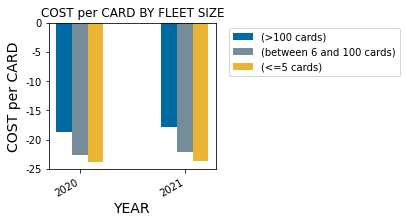

In [20]:
colors = ['#006BA2','#758D99','#EBB434']
labels = ['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)']

fig, ax = plt.subplots(1, figsize=(3,3))

bar_width = 0.15
max_value = 0

s = '(>100 cards)'
x_axis = np.arange(len(df_cost_per_card[df_cost_per_card.FLEET_SIZE_GROUP==s]))

for idx,s in enumerate(labels):
    
    print(s)

    dim1 = list(map(str,df_cost_per_card[df_cost_per_card.FLEET_SIZE_GROUP==s].REVENUE_YEAR))
    data1 = df_cost_per_card[df_cost_per_card.FLEET_SIZE_GROUP==s].COST_PER_CARD
    if idx==0:
        ax.bar(x_axis-bar_width, data1, color=colors[idx], width=bar_width)

    if idx==1:
        ax.bar(x_axis, data1, color=colors[idx], width=bar_width)

    if idx==2:
        ax.bar(x_axis+bar_width, data1, color=colors[idx], width=bar_width)

ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('COST per CARD', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('COST per CARD BY FLEET SIZE')
plt.legend(labels, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.xticks(x_axis, dim1)
plt.show()

In [0]:
#COST_BY_SEGMENT_df = ... # Compute a Pandas dataframe to write into COST_BY_SEGMENT

# Write recipe outputs
#COST_BY_SEGMENT = dataiku.Dataset("COST_BY_SEGMENT")
#COST_BY_SEGMENT.write_with_schema(COST_BY_SEGMENT_df)